## Descripción <a class="tocSkip"></a>

Los clientes de Beta Bank se están yendo, cada mes, poco a poco. Los banqueros descubrieron que es más barato salvar a los clientes existentes que atraer nuevos.

Necesitamos predecir si un cliente dejará el banco pronto. Tú tienes los datos sobre el comportamiento pasado de los clientes y la terminación de contratos con el banco.

Crea un modelo con el máximo valor F1 posible. Para aprobar la revisión, necesitas un valor F1 de al menos 0.59. Verifica F1 para el conjunto de prueba. 

Además, debes medir la métrica AUC-ROC y compararla con el valor F1.


Características

RowNumber: índice de cadena de datos
CustomerId: identificador de cliente único
Surname: apellido
CreditScore: valor de crédito
Geography: país de residencia
Gender: sexo
Age: edad
Tenure: período durante el cual ha madurado el depósito a plazo fijo de un cliente (años)
Balance: saldo de la cuenta
NumOfProducts: número de productos bancarios utilizados por el cliente
HasCrCard: el cliente tiene una tarjeta de crédito (1 - sí; 0 - no)
IsActiveMember: actividad del cliente (1 - sí; 0 - no)
EstimatedSalary: salario estimado
Objetivo

Exited: El cliente se ha ido (1 - sí; 0 - no)

----

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    df = pd.read_csv('Churn.csv') # Intenta cargar los datos desde la ruta local
except FileNotFoundError:
    df = pd.read_csv('/datasets/Churn.csv') # Si no lo encuentra, intenta desde la ruta del servidor

In [3]:
print("Primeras 5 filas del DataFrame:")
print(df.head())
print("\nInformación general del DataFrame:")
print(df.info())
print("\nEstadísticas descriptivas de las columnas numéricas:")
print(df.describe())
print("\nValores únicos y conteo de la columna 'Exited':")
print(df['Exited'].value_counts())
print("\nValores únicos y conteo de la columna 'Geography':")
print(df['Geography'].value_counts())
print("\nValores únicos y conteo de la columna 'Gender':")
print(df['Gender'].value_counts())
print("\nValores faltantes por columna:")
print(df.isnull().sum())

Primeras 5 filas del DataFrame:
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0     2.0       0.00              1          1               1   
1     1.0   83807.86              1          0               1   
2     8.0  159660.80              3          1               0   
3     1.0       0.00              2          0               0   
4     2.0  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         

In [4]:
median_tenure = df['Tenure'].median()
df['Tenure'] = df['Tenure'].fillna(median_tenure)

print("\nValores faltantes después de la imputación:")
print(df.isnull().sum())


Valores faltantes después de la imputación:
RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


In [5]:
df = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)
print("\nPrimeras 5 filas del DataFrame después de la codificación OHE:")
print(df.head())


Primeras 5 filas del DataFrame después de la codificación OHE:
   RowNumber  CustomerId   Surname  CreditScore  Age  Tenure    Balance  \
0          1    15634602  Hargrave          619   42     2.0       0.00   
1          2    15647311      Hill          608   41     1.0   83807.86   
2          3    15619304      Onio          502   42     8.0  159660.80   
3          4    15701354      Boni          699   39     1.0       0.00   
4          5    15737888  Mitchell          850   43     2.0  125510.82   

   NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited  \
0              1          1               1        101348.88       1   
1              1          0               1        112542.58       0   
2              3          1               0        113931.57       1   
3              2          0               0         93826.63       0   
4              1          1               1         79084.10       0   

   Geography_Germany  Geography_Spain  Gender_Male  

In [6]:
numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

print("\nPrimeras 5 filas del DataFrame después del escalado:")
print(df.head())


Primeras 5 filas del DataFrame después del escalado:
   RowNumber  CustomerId   Surname  CreditScore       Age    Tenure   Balance  \
0          1    15634602  Hargrave    -0.326221  0.293517 -1.086246 -1.225848   
1          2    15647311      Hill    -0.440036  0.198164 -1.448581  0.117350   
2          3    15619304      Onio    -1.536794  0.293517  1.087768  1.333053   
3          4    15701354      Boni     0.501521  0.007457 -1.448581 -1.225848   
4          5    15737888  Mitchell     2.063884  0.388871 -1.086246  0.785728   

   NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited  \
0      -0.911583          1               1         0.021886       1   
1      -0.911583          0               1         0.216534       0   
2       2.527057          1               0         0.240687       1   
3       0.807737          0               0        -0.108918       0   
4      -0.911583          1               1        -0.365276       0   

   Geography_Germany  Geog

In [7]:
# Separar características y objetivo
features = df.drop(['RowNumber', 'CustomerId', 'Surname', 'Exited'], axis=1)
target = df['Exited']

# Dividir en entrenamiento (60%) y el resto (40%)
features_train, features_temp, target_train, target_temp = train_test_split(
    features, target, test_size=0.4, random_state=12345
)

# Dividir el conjunto temporal en validación (20%) y prueba (20%)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_temp, target_temp, test_size=0.5, random_state=12345
)

# Imprimir el tamaño de los conjuntos resultantes
print("Tamaño del conjunto de entrenamiento:", features_train.shape)
print("Tamaño del conjunto de validación:", features_valid.shape)
print("Tamaño del conjunto de prueba:", features_test.shape)

Tamaño del conjunto de entrenamiento: (6000, 11)
Tamaño del conjunto de validación: (2000, 11)
Tamaño del conjunto de prueba: (2000, 11)


In [8]:
print("Distribución de clases en la columna 'Exited':")
print(target_train.value_counts(normalize=True))  # Muestra las proporciones en el conjunto de entrenamiento

Distribución de clases en la columna 'Exited':
0    0.800667
1    0.199333
Name: Exited, dtype: float64


Puntaje F1 en el conjunto de validación: 0.33108108108108103
AUC-ROC en el conjunto de validación: 0.7588057029137607
Puntaje F1 en el conjunto de prueba: 0.27177700348432055
AUC-ROC en el conjunto de prueba: 0.7387204660373483


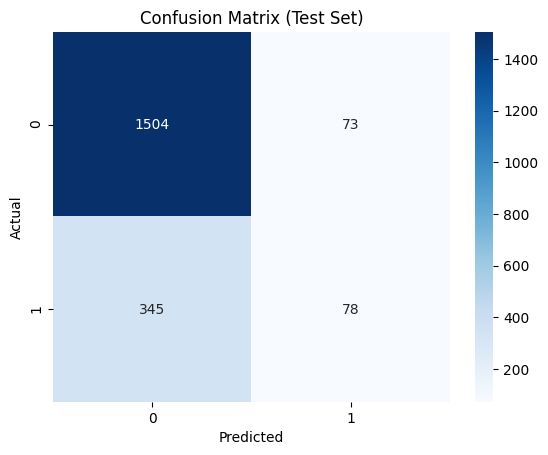

In [9]:
# Inicializar el modelo de Regresión Logística
model = LogisticRegression(random_state=12345)

# Entrenar el modelo con los datos de entrenamiento
model.fit(features_train, target_train)

# Predecir las probabilidades en los conjuntos de validación y prueba
probabilities_valid = model.predict_proba(features_valid)[:, 1]
probabilities_test = model.predict_proba(features_test)[:, 1]

# Predecir las clases en los conjuntos de validación y prueba
predictions_valid = model.predict(features_valid)
predictions_test = model.predict(features_test)

# Calcular el puntaje F1 en los conjuntos de validación y prueba
f1_valid = f1_score(target_valid, predictions_valid)
f1_test = f1_score(target_test, predictions_test)

# Calcular el AUC-ROC en los conjuntos de validación y prueba
auc_roc_valid = roc_auc_score(target_valid, probabilities_valid)
auc_roc_test = roc_auc_score(target_test, probabilities_test)

print("Puntaje F1 en el conjunto de validación:", f1_valid)
print("AUC-ROC en el conjunto de validación:", auc_roc_valid)
print("Puntaje F1 en el conjunto de prueba:", f1_test)
print("AUC-ROC en el conjunto de prueba:", auc_roc_test)

# Generar y mostrar la matriz de confusión en el conjunto de prueba
cm = confusion_matrix(target_test, predictions_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Set)')
plt.show()

Mejores parámetros: {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
Mejor puntaje F1: 0.5036695988540064
Puntaje F1 en el conjunto de prueba (Regresión Logística): 0.4986498649864987
AUC-ROC en el conjunto de prueba (Regresión Logística): 0.7517857919172021


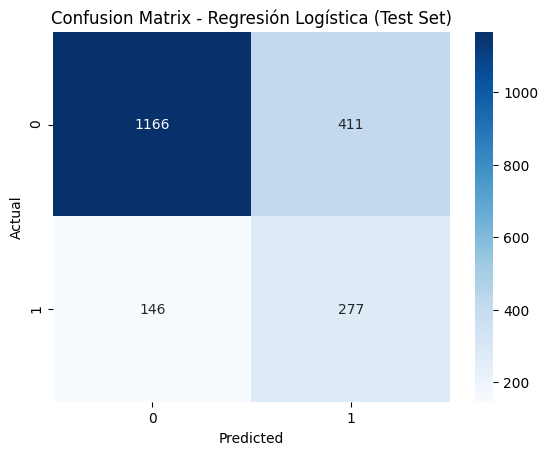

In [10]:
# Definir los parámetros para la búsqueda de cuadrícula
param_grid = {'penalty': ['l1', 'l2'], # Tipos de regularización
              'C': [0.001, 0.01, 0.1, 1, 10, 100], # Valores para la fuerza de regularización
              'solver': ['liblinear', 'saga'], # Algoritmos para la optimización
              'class_weight': ['balanced'] # Ponderación de clases
             }

# Inicializar GridSearchCV con el modelo de Regresión Logística
grid_search = GridSearchCV(LogisticRegression(random_state=12345, max_iter=1000),
                           param_grid,
                           scoring='f1',
                           cv=3,  # Usar validación cruzada K-fold con 3 folds
                           n_jobs=-1) # Usar todos los núcleos disponibles

# Ajustar GridSearchCV a los datos de entrenamiento
grid_search.fit(features_train, target_train)

# Imprimir los mejores parámetros y el mejor puntaje F1 encontrado
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor puntaje F1:", grid_search.best_score_)

# Obtener el mejor modelo
best_model_lr = grid_search.best_estimator_

# Predecir las probabilidades en el conjunto de prueba con el mejor modelo
probabilities_test_lr = best_model_lr.predict_proba(features_test)[:, 1]

# Predecir las clases en el conjunto de prueba con el mejor modelo
predictions_test_lr = best_model_lr.predict(features_test)

# Calcular el puntaje F1 y el AUC-ROC en el conjunto de prueba con el mejor modelo
f1_test_lr = f1_score(target_test, predictions_test_lr)
auc_roc_test_lr = roc_auc_score(target_test, probabilities_test_lr)

print("Puntaje F1 en el conjunto de prueba (Regresión Logística):", f1_test_lr)
print("AUC-ROC en el conjunto de prueba (Regresión Logística):", auc_roc_test_lr)

# Matriz de confusión
cm_lr = confusion_matrix(target_test, predictions_test_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Regresión Logística (Test Set)')
plt.show()

Mejores parámetros (Random Forest): {'class_weight': 'balanced', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 200}
Mejor puntaje F1 (Random Forest): 0.6195138109693712
Puntaje F1 en el conjunto de prueba (Random Forest): 0.6168623265741728
AUC-ROC en el conjunto de prueba (Random Forest): 0.858899577406303


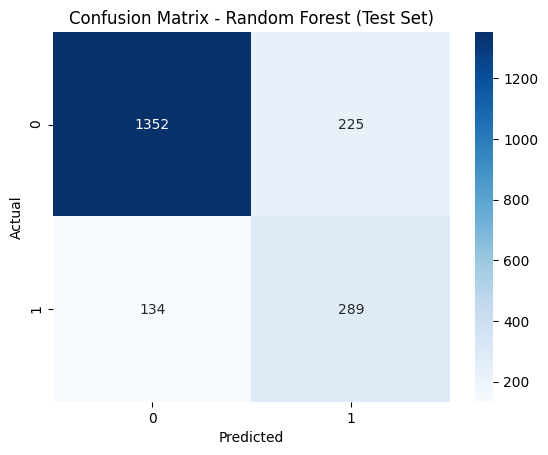

In [11]:
# Definir la grilla de hiperparámetros para la búsqueda
param_grid_rf = {'n_estimators': [50, 100, 200],
                  'max_depth': [4, 6, 8],
                  'min_samples_split': [2, 4, 8],
                  'min_samples_leaf': [1, 2, 3],
                  'class_weight': ['balanced']}

# Inicializar GridSearchCV con el modelo de Random Forest
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=12345),
                              param_grid_rf,
                              scoring='f1',
                              cv=3, # Usar validación cruzada K-fold con 3 folds
                              n_jobs=-1) # Usar todos los núcleos disponibles

# Ajustar GridSearchCV a los datos de entrenamiento
grid_search_rf.fit(features_train, target_train)

# Imprimir los mejores parámetros y el mejor puntaje F1 encontrado
print("Mejores parámetros (Random Forest):", grid_search_rf.best_params_)
print("Mejor puntaje F1 (Random Forest):", grid_search_rf.best_score_)

# Obtener el mejor modelo de Random Forest
best_model_rf = grid_search_rf.best_estimator_

# Predecir las probabilidades en el conjunto de prueba con el mejor modelo de Random Forest
probabilities_test_rf = best_model_rf.predict_proba(features_test)[:, 1]

# Predecir las clases en el conjunto de prueba con el mejor modelo de Random Forest
predictions_test_rf = best_model_rf.predict(features_test)

# Calcular el puntaje F1 y el AUC-ROC en el conjunto de prueba con el mejor modelo de Random Forest
f1_test_rf = f1_score(target_test, predictions_test_rf)
auc_roc_test_rf = roc_auc_score(target_test, probabilities_test_rf)

print("Puntaje F1 en el conjunto de prueba (Random Forest):", f1_test_rf)
print("AUC-ROC en el conjunto de prueba (Random Forest):", auc_roc_test_rf)

# Matriz de confusión
cm_rf = confusion_matrix(target_test, predictions_test_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest (Test Set)')
plt.show()
